# Step 1: Best Contour Extraction/Prediction

In [5]:
orig_dir = 'CV-Assignment-Dataset'   #Test Images Directory
dest_dir = 'plot'                    #images stored with ROI boxes

In [78]:
from image_process import (
    threshold,
    morphology,
    find_contours,
    extra_contour_elimination,
    crop_contour,
    req_contour
)
import csv
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%pylab inline --no-import-all

Populating the interactive namespace from numpy and matplotlib


In [79]:
from keras.models import load_model
model = load_model('model.hdf5')

In [122]:
def plot(filename,file,target):
    img = cv2.imread(filename)
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    clone = img.copy()
    thresh = threshold(img)
    img, lines = find_contours(thresh)
    final_lines = extra_contour_elimination(lines)
    req = []
    for i,line in enumerate(final_lines):
        _, L = crop_contour(line,thresh)
        img = cv2.resize(L,(28,28))
        data = img.reshape(1,28,28,1)
        model_out = model.predict([data])

        if np.argmax(model_out)==1:
            str_label = '0'
        else:
            str_label = '1'

        if str_label=='1':
            print(file)
            req.append(i)
            name = dest_dir+'/'+file
#             print(name)
            rect = cv2.minAreaRect(line)
            box = cv2.boxPoints(rect)
            box = np.int0(box)
#             boxes.append(box)
            cv2.drawContours(clone,[box],0,(0,255,0),2)
            xmin = min(box[:,0])
            xmax = max(box[:,0])
            ymin = min(box[:,1])
            ymax = max(box[:,1])
            crop = [xmin,xmax,ymin,ymax]
            target.append([file,thresh,line,crop])
            cv2.imwrite(name,clone)
#     for index in req:
# #         print(final_lines[index])
#         rect = cv2.minAreaRect(final_lines[index])
#         box = cv2.boxPoints(rect)
#         box = np.int0(box)
#         boxes.append(box)
#         cv2.drawContours(clone,[box],0,(0,255,0),2)
#         cv2.imwrite(name,clone)
    cv2.imwrite("test.jpeg",thresh)
#     print(boxes[0])
    return target

In [127]:
target = []
# for file in os.listdir(orig_dir):
# path = os.path.join(orig_dir,file)
target = plot('CV-Assignment-Dataset/DJI_0036.JPG','DJI_0036.JPG',target)
print(target[0][3])
boundary = target[0][3]
# cv2.imwrite("crop.jpeg",crop),

DJI_0036.JPG
[1714, 1762, 2581, 2634]


# Step 2: Point of L extraction

Extraction using Center of mass, since the required coordinates lie near COM of L

In [126]:
# def get_coordinates(line)    
def get_com(contours):
#     filename = 'data/train/1/230.jpeg'
#     image = cv2.imread(filename)
#     imgray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#     gray = imgray.copy()
#     _, thresh = cv2.threshold(imgray, 220, 255, 0)
#     _, contours, hierarchy = cv2.findContours(thresh, cv2.cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # cnts = cv2.drawContours(image, contours[0], -1, (0, 255, 0), 1)

    kpCnt = len(contours)

    x = 0
    y = 0

    for kp in contours:
        x = x+kp[0][0]
        y = y+kp[0][1]

    #     cv2.circle(image, (np.uint8(np.ceil(x/kpCnt)), np.uint8(np.ceil(y/kpCnt))), 1, (0, 255, 255),1 )

    com = np.array([x/kpCnt,y/kpCnt])
    return com

    #     print((x/kpCnt),(y/kpCnt))
    #     plt.imshow(cnts)

In [132]:
def check(rect,pt):
    logic = rect[0] < pt[0] < rect[1] and rect[2] < pt[1] < rect[3]
    return logic

In [133]:
def get_gcp(gray,com,boundary):
    plt.imshow(gray)
    dst = cv2.cornerHarris(gray,2,3,0.04)
    dst = cv2.dilate(dst,None)
    ret, dst = cv2.threshold(dst,0.001*dst.max(),255,0)
    dst = np.uint8(dst)

    # find centroids
    ret, labels, stats, centroids = cv2.connectedComponentsWithStats(dst)


    # define the criteria to stop and refine the corners
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.001)
    corners = cv2.cornerSubPix(gray,np.float32(centroids),(3,3),(-1,-1),criteria)
#     print(corners[:,1])
    dist_min = 1000000
    
    # Extra contour elimination
    for i,corner in enumerate(corners):
        ans = check(boundary,corner)
        if not ans:
            np.delete(corners,i)
    #check of eucliedien     
    for corner in corners:
        euc_dist = np.linalg.norm(corner - com)
        if euc_dist<dist_min:
            dist_min = euc_dist
            gcp = corner
    return gcp
# Now draw them
# res = np.hstack((centroids,corners))
# res = np.int0(res)
# image[res[:,1],res[:,0]]=[0,0,255]
# image[res[:,3],res[:,2]] = [0,255,0]

# cv2.imwrite('subpixel5.png',image)
# plt.imshow(image)
# print(corners)
# print(gray[10,9])

[1733.09375 2599.     ]
[1742.4098 2597.1355]


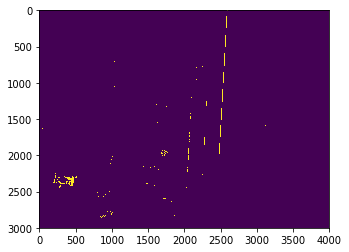

In [134]:
com = get_com(target[0][2])
gcp = get_gcp(target[0][1],com,boundary)
# scale = target[0][3]
# o_shape = target[0][4]
# gcp_x = scale[0]*gcp[0]/(o_shape[1])
# gcp_y = scale[1]*gcp[1]/o_shape[0]
print(com)
# print(scale)
print(gcp)
# print(gcp_x,gcp_y)